In [ ]:
# Load and initialize the dataset
# Import pandas for data manipulation
import pandas as pd

# Read the CSV file containing Twitter dataset into a DataFrame
# The dataset contains tweets related to climate change
df = pd.read_csv(r"A:\projects\project_sna\data\raw\The Climate Change Twitter Dataset.csv")
df.head()  # Display first 5 rows to verify data loading

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive
2,2006-08-29 01:52:30+00:00,23160,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive
3,2006-11-07 02:46:52+00:00,57868,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive


In [ ]:
# Data preprocessing and cleanup
# Select only the columns we need for analysis
df = df[['created_at', 'topic', 'sentiment', 'stance', 'gender', 'aggressiveness']].dropna(subset=['topic'])

# Clean topic strings by removing leading/trailing whitespace
df['topic'] = df['topic'].str.strip()

# Display cleaned data sample
df.head()  # Show first 5 rows of processed dataset

,created_at,topic,sentiment,stance,gender,aggressiveness
0,2006-06-06 16:06:42+00:00,Weather Extremes,-0.097180,neutral,female,aggressive
1,2006-07-23 21:52:30+00:00,Weather Extremes,0.575777,neutral,undefined,aggressive
2,2006-08-29 01:52:30+00:00,Weather Extremes,0.500479,neutral,male,aggressive
3,2006-11-07 02:46:52+00:00,Weather Extremes,0.032816,neutral,male,aggressive
4,2006-11-27 14:27:43+00:00,Importance of Human Intervantion,-0.090428,neutral,male,aggressive


In [ ]:
# Generate topic co-occurrence network edges
import itertools

# Convert timestamps to monthly periods for temporal aggregation
df['month'] = pd.to_datetime(df['created_at']).dt.to_period('M')

# Initialize empty list to store topic pairs (edges)
edges = []

# For each month in the dataset
for month, group in df.groupby('month'):
    # Get unique topics for the month
    topics = group['topic'].value_counts().index.tolist()
    # Generate all possible pairs of topics (undirected edges)
    for t1, t2 in itertools.combinations(topics, 2):
        edges.append((t1, t2))

# Create DataFrame of edges and count co-occurrences
edges_df = pd.DataFrame(edges, columns=['source', 'target'])
edges_df = edges_df.groupby(['source', 'target']).size().reset_index(name='weight')
edges_df.head()  # Display sample of edge list with weights

C:\Users\prane\AppData\Local\Temp\ipykernel_19844\819600810.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = pd.to_datetime(df['created_at']).dt.to_period('M')


,source,target,weight
0,Donald Trump versus Science,Global stance,52
1,Donald Trump versus Science,Ideological Positions on Global Warming,119
2,Donald Trump versus Science,Impact of Resource Overconsumption,149
3,Donald Trump versus Science,Importance of Human Intervantion,60
4,Donald Trump versus Science,Politics,81


In [ ]:
# Persist edge data
# Save the topic co-occurrence network edges to CSV for future analysis
edges_df.to_csv(r"A:\projects\project_sna\data\processed\topic_edges.csv", index=False)
print("✅ Saved topic co-occurrence edges.")

✅ Saved topic co-occurrence edges.


In [ ]:
# Create NetworkX graph from edge data
import networkx as nx

# Read the saved edges from CSV
edges = pd.read_csv(r"A:\projects\project_sna\data\processed\topic_edges.csv")

# Initialize an undirected graph
G = nx.Graph()

# Add edges with weights to the graph
for _, row in edges.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

# Print basic network statistics
print("✅ Network built.")
print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

✅ Network built.
Nodes: 10 Edges: 45


In [ ]:
# Calculate network centrality metrics
# Compute three types of centrality measures for each node:
deg = nx.degree_centrality(G)      # Degree centrality: proportion of nodes that a node is connected to
bet = nx.betweenness_centrality(G) # Betweenness: frequency of node appearing on shortest paths
clo = nx.closeness_centrality(G)   # Closeness: average shortest path length to all other nodes

# Combine all centrality metrics into a single DataFrame
data = []
for n in G.nodes():
    data.append({
        "topic": n,
        "degree_centrality": deg[n],
        "betweenness": bet[n],
        "closeness": clo[n],
    })

# Create DataFrame and sort by degree centrality
df_centrality = pd.DataFrame(data).sort_values('degree_centrality', ascending=False)
df_centrality.to_csv(r"A:\projects\project_sna\outputs\topic_centrality.csv", index=False)
df_centrality.head(10)  # Display top 10 topics by degree centrality

,topic,degree_centrality,betweenness,closeness
0,Donald Trump versus Science,1.0,0.0,1.0
1,Global stance,1.0,0.0,1.0
2,Ideological Positions on Global Warming,1.0,0.0,1.0
3,Impact of Resource Overconsumption,1.0,0.0,1.0
4,Importance of Human Intervantion,1.0,0.0,1.0
5,Politics,1.0,0.0,1.0
6,Seriousness of Gas Emissions,1.0,0.0,1.0
7,Significance of Pollution Awareness Events,1.0,0.0,1.0
8,Undefined / One Word Hashtags,1.0,0.0,1.0
9,Weather Extremes,1.0,0.0,1.0


In [8]:
# Detect communities using the Louvain method and save community assignments
import community as community_louvain

partition = community_louvain.best_partition(G)
parts = pd.DataFrame(list(partition.items()), columns=['topic', 'community'])
parts.to_csv(r"A:\projects\project_sna\outputs\topic_communities.csv", index=False)
print("✅ Communities detected:", parts['community'].nunique())



✅ Communities detected: 2


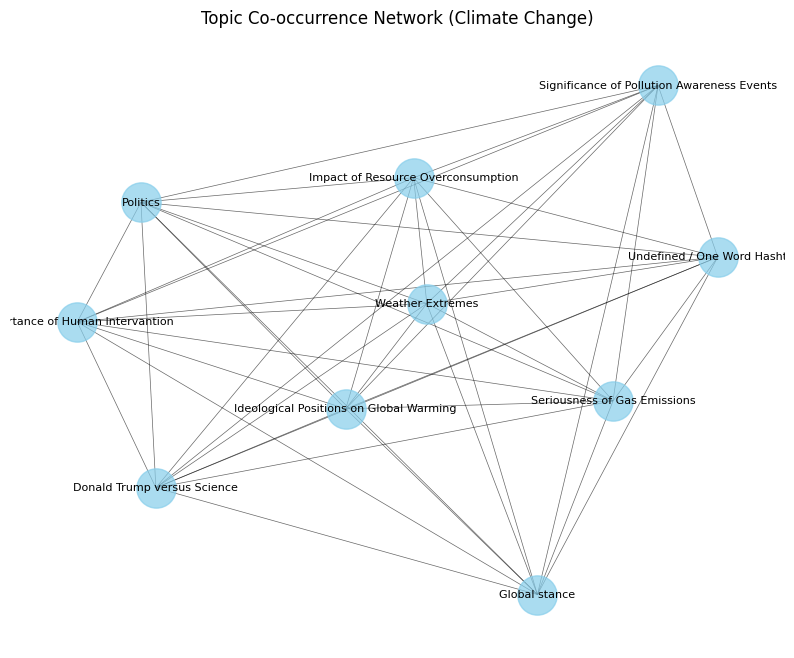

In [ ]:
# Visualize topic co-occurrence network
import matplotlib.pyplot as plt

# Create a spring layout for the graph (force-directed layout)
pos = nx.spring_layout(G, seed=42)  # seed for reproducibility

# Set up the plot
plt.figure(figsize=(10,8))

# Draw network components
nx.draw_networkx_nodes(G, pos, node_size=800, node_color='skyblue', alpha=0.7)  # Draw nodes
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.6)  # Draw edges
nx.draw_networkx_labels(G, pos, font_size=8)  # Add node labels

# Customize plot
plt.title("Topic Co-occurrence Network (Climate Change)")
plt.axis("off")  # Hide axes
plt.show()

In [10]:
# Merge centrality and community assignments to create combined metrics file for reporting
import pandas as pd

cent = pd.read_csv(r"A:\projects\project_sna\outputs\topic_centrality.csv")
comm = pd.read_csv(r"A:\projects\project_sna\outputs\topic_communities.csv")

merged = cent.merge(comm, on='topic', how='left')
merged.to_csv(r"A:\projects\project_sna\outputs\topic_metrics_combined.csv", index=False)

print(merged.groupby('community').size())



community
0    5
1    5
dtype: int64


In [11]:
# Print a simple summary of topics per community and show top topics by degree centrality in each community
parts = pd.read_csv(r"A:\projects\project_sna\outputs\topic_communities.csv")
cent = pd.read_csv(r"A:\projects\project_sna\outputs\topic_centrality.csv")

merged = cent.merge(parts, on='topic', how='left')
for cid, group in merged.groupby('community'):
    print(f"\n🌎 Community {cid} — {len(group)} topics")
    print(group.sort_values('degree_centrality', ascending=False)[['topic', 'degree_centrality']])




🌎 Community 0 — 5 topics
                                        topic  degree_centrality
0                 Donald Trump versus Science                1.0
1                               Global stance                1.0
7  Significance of Pollution Awareness Events                1.0
8               Undefined / One Word Hashtags                1.0
9                            Weather Extremes                1.0

🌎 Community 1 — 5 topics
                                     topic  degree_centrality
2  Ideological Positions on Global Warming                1.0
3       Impact of Resource Overconsumption                1.0
4         Importance of Human Intervantion                1.0
5                                 Politics                1.0
6             Seriousness of Gas Emissions                1.0


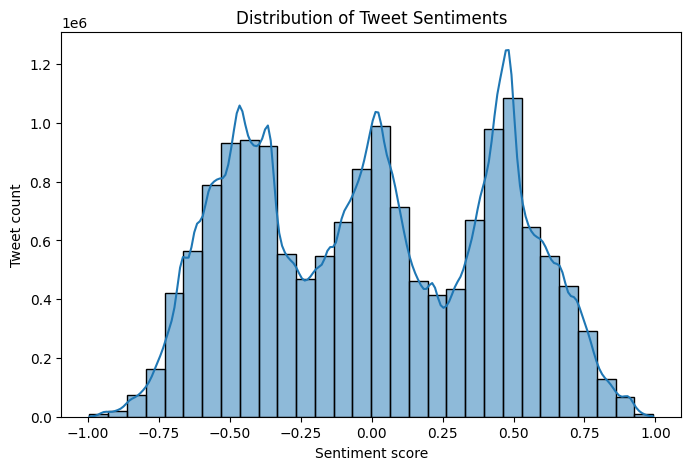

In [ ]:
# Visualize sentiment distribution
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with specified size
plt.figure(figsize=(8,5))

# Create histogram with kernel density estimation
sns.histplot(df['sentiment'], bins=30, kde=True)  # kde=True adds density curve

# Add plot labels and title
plt.title("Distribution of Tweet Sentiments")
plt.xlabel("Sentiment score")
plt.ylabel("Tweet count")
plt.show()

C:\Users\prane\AppData\Local\Temp\ipykernel_19844\2356565639.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = pd.to_datetime(df['created_at']).dt.to_period('M')


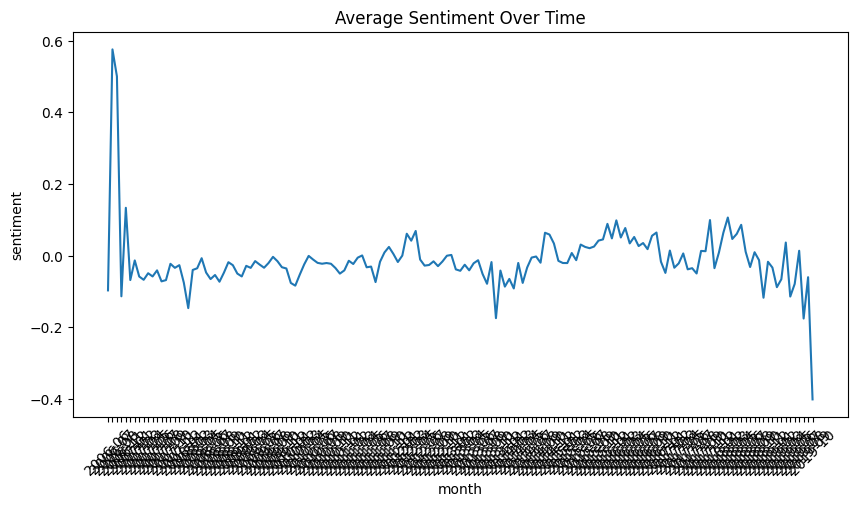

In [13]:
# Compute average sentiment per month and plot a time series of average sentiment
df['month'] = pd.to_datetime(df['created_at']).dt.to_period('M')
monthly_sentiment = df.groupby('month')['sentiment'].mean().reset_index()
monthly_sentiment['month'] = monthly_sentiment['month'].astype(str)

plt.figure(figsize=(10,5))
sns.lineplot(data=monthly_sentiment, x='month', y='sentiment')
plt.title("Average Sentiment Over Time")
plt.xticks(rotation=45)
plt.show()



In [14]:
# Re-load a minimal DataFrame with topic and sentiment, clean it, compute average sentiment per topic and save
import pandas as pd
import numpy as np

df = pd.read_csv(r"A:\projects\project_sna\data\raw\The Climate Change Twitter Dataset.csv")

# Clean up
df = df[['topic', 'sentiment']].dropna()
df['topic'] = df['topic'].str.strip()

# Compute average sentiment for each topic
topic_sent = df.groupby('topic')['sentiment'].mean().reset_index()
topic_sent.columns = ['topic', 'avg_sentiment']
topic_sent.to_csv(r"A:\projects\project_sna\data\processed\topic_sentiment.csv", index=False)
topic_sent.head()



,topic,avg_sentiment
0,Donald Trump versus Science,-0.159700
1,Global stance,0.069316
2,Ideological Positions on Global Warming,-0.197715
3,Impact of Resource Overconsumption,-0.103795
4,Importance of Human Intervantion,0.069617


In [15]:
# Create sentiment-similarity edges between topics whose average sentiments are within a threshold
import itertools

edges = []
threshold = 0.1  # tweak this for stricter or looser connections

for t1, t2 in itertools.combinations(topic_sent['topic'], 2):
    s1 = topic_sent.loc[topic_sent['topic']==t1, 'avg_sentiment'].values[0]
    s2 = topic_sent.loc[topic_sent['topic']==t2, 'avg_sentiment'].values[0]
    diff = abs(s1 - s2)
    if diff <= threshold:
        edges.append((t1, t2, 1 - diff))  # weight = similarity (1 - diff)

edges_df = pd.DataFrame(edges, columns=['source', 'target', 'weight'])
edges_df.to_csv(r"A:\projects\project_sna\data\processed\sentiment_edges.csv", index=False)
print(f"✅ Created {len(edges_df)} sentiment-based edges.")



✅ Created 18 sentiment-based edges.


Nodes: 9 Edges: 18


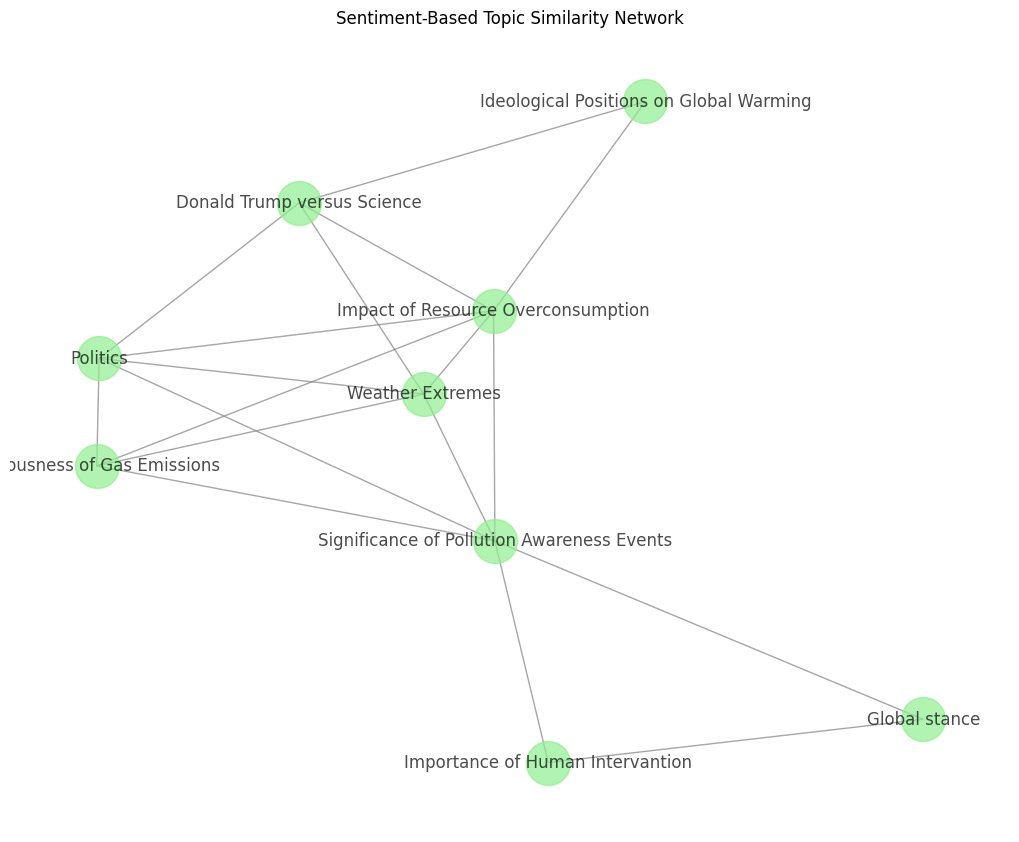

In [16]:
# Build and visualize a sentiment-based topic similarity network from saved edges
import networkx as nx
import matplotlib.pyplot as plt

edges = pd.read_csv(r"A:\projects\project_sna\data\processed\sentiment_edges.csv")

G = nx.Graph()
for _, row in edges.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

print("Nodes:", G.number_of_nodes(), "Edges:", G.number_of_edges())

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10,8))
nx.draw(G, pos, with_labels=True, node_color='lightgreen', edge_color='gray', node_size=1000, alpha=0.7)
plt.title("Sentiment-Based Topic Similarity Network")
plt.show()



In [17]:
# Create a DataFrame of degree centrality values for the sentiment network and show top topics by degree
deg = nx.degree_centrality(G)
df_central = pd.DataFrame({'topic': list(deg.keys()), 'degree_centrality': list(deg.values())})
df_central.sort_values('degree_centrality', ascending=False).head()



,topic,degree_centrality
2,Impact of Resource Overconsumption,0.750
7,Significance of Pollution Awareness Events,0.750
4,Weather Extremes,0.625
3,Politics,0.625
0,Donald Trump versus Science,0.500


In [ ]:
# Prepare data for temporal network analysis
# Re-load raw data to ensure clean start
df = pd.read_csv(r"A:\projects\project_sna\data\raw\The Climate Change Twitter Dataset.csv")

# Convert created_at to datetime and extract year
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')  # coerce invalid dates to NaT
df['year'] = df['created_at'].dt.year

# Clean data: remove rows with missing topics or dates
df = df.dropna(subset=['topic', 'year'])
df['topic'] = df['topic'].str.strip()

# Display sample of processed data
df.head()

,created_at,id,lng,lat,topic,sentiment,stance,gender,temperature_avg,aggressiveness,year
0,2006-06-06 16:06:42+00:00,6132,NaN,NaN,Weather Extremes,-0.097180,neutral,female,NaN,aggressive,2006
1,2006-07-23 21:52:30+00:00,13275,-73.949582,40.650104,Weather Extremes,0.575777,neutral,undefined,-1.114768,aggressive,2006
2,2006-08-29 01:52:30+00:00,23160,NaN,NaN,Weather Extremes,0.500479,neutral,male,NaN,aggressive,2006
3,2006-11-07 02:46:52+00:00,57868,NaN,NaN,Weather Extremes,0.032816,neutral,male,NaN,aggressive,2006
4,2006-11-27 14:27:43+00:00,304553,NaN,NaN,Importance of Human Intervantion,-0.090428,neutral,male,NaN,aggressive,2006


In [ ]:
# Create yearly topic co-occurrence networks
import itertools
import os

# Set up output directory for temporal network files
base_path = r"A:\projects\project_sna\data\processed\temporal_networks"
os.makedirs(base_path, exist_ok=True)

# Process data year by year
for year, group in df.groupby('year'):
    # Get unique topics for the year
    topics = group['topic'].value_counts().index.tolist()
    
    # Generate edges (topic pairs)
    edges = []
    for t1, t2 in itertools.combinations(topics, 2):
        edges.append((t1, t2))
    
    # Create and process edges DataFrame
    edges_df = pd.DataFrame(edges, columns=['source', 'target'])
    edges_df = edges_df.groupby(['source', 'target']).size().reset_index(name='weight')
    
    # Save yearly network
    out_path = os.path.join(base_path, f"edges_{year}.csv")
    edges_df.to_csv(out_path, index=False)
    print(f"✅ Year {year}: {len(edges_df)} edges saved.")

✅ Year 2006: 10 edges saved.
✅ Year 2007: 45 edges saved.
✅ Year 2008: 45 edges saved.
✅ Year 2009: 45 edges saved.
✅ Year 2010: 45 edges saved.
✅ Year 2011: 45 edges saved.
✅ Year 2012: 45 edges saved.
✅ Year 2013: 45 edges saved.
✅ Year 2014: 45 edges saved.
✅ Year 2015: 45 edges saved.
✅ Year 2016: 45 edges saved.
✅ Year 2015: 45 edges saved.
✅ Year 2016: 45 edges saved.
✅ Year 2017: 45 edges saved.
✅ Year 2018: 45 edges saved.
✅ Year 2019: 45 edges saved.
✅ Year 2017: 45 edges saved.
✅ Year 2018: 45 edges saved.
✅ Year 2019: 45 edges saved.


In [ ]:
# Analyze temporal evolution of topic networks
import networkx as nx
import glob

# Initialize list to store yearly network metrics
yearly_results = []

# Process each year's network file
for file in glob.glob(r"A:\projects\project_sna\data\processed\temporal_networks\edges_*.csv"):
    # Extract year from filename
    year = int(file.split('_')[-1].split('.')[0])
    
    # Load edges and create network
    edges = pd.read_csv(file)
    G = nx.Graph()
    for _, row in edges.iterrows():
        G.add_edge(row['source'], row['target'], weight=row['weight'])
    
    # Calculate network metrics
    deg = nx.degree_centrality(G)
    top_topic = max(deg, key=deg.get) if deg else None  # Most central topic
    
    # Store yearly summary
    yearly_results.append({
        "year": year,
        "top_topic": top_topic,
        "num_nodes": len(G),  # Number of topics
        "num_edges": G.number_of_edges()  # Number of topic connections
    })

# Display yearly network evolution
pd.DataFrame(yearly_results).sort_values('year')

,year,top_topic,num_nodes,num_edges
0,2006,Ideological Positions on Global Warming,5,10
1,2007,Donald Trump versus Science,10,45
2,2008,Donald Trump versus Science,10,45
3,2009,Donald Trump versus Science,10,45
4,2010,Donald Trump versus Science,10,45
5,2011,Donald Trump versus Science,10,45
6,2012,Donald Trump versus Science,10,45
7,2013,Donald Trump versus Science,10,45
8,2014,Donald Trump versus Science,10,45
9,2015,Donald Trump versus Science,10,45


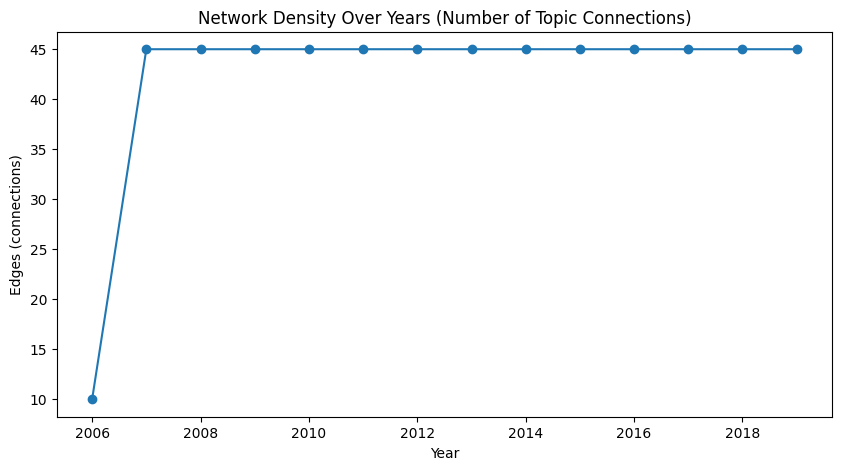

In [ ]:
# Visualize network evolution over time
import matplotlib.pyplot as plt
import pandas as pd

# Create trend DataFrame sorted by year
trend = pd.DataFrame(yearly_results).sort_values('year')

# Plot network density evolution
plt.figure(figsize=(10,5))
plt.plot(trend['year'], trend['num_edges'], marker='o')  # Line plot with markers
plt.title("Network Density Over Years (Number of Topic Connections)")
plt.xlabel("Year")
plt.ylabel("Edges (connections)")
plt.show()